In [ ]:
import numpy as np  # numpy for math
import pandas as pd       # for dataframes and csv files
import matplotlib.pyplot as plt  # for plotting
from matplotlib import animation  # animate 3D plots
from mpl_toolkits.mplot3d import Axes3D  # 3D plots

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.losses import SparseCategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
#Load data as a Pandas DF
data=pd.read_csv('places_data.csv')
data.shape   # what is the size of the data?

(289, 302)

In [ ]:
#Creating Separate Dataset for the Output
data_features = data.copy().dropna()
revenue = data_features['All_Revenue']
print(revenue)

In [ ]:
#Drop Columns that are not Numerical Values
data_features.drop(data_features.columns[[0,1,2,3,4,5,6,9,299,300]], axis=1, inplace=True)

In [ ]:
print(data_features)

In [ ]:
inputs = {}
for name, column in data_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

In [ ]:
# deal with numeric features
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(data_features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
preprocessed_inputs = [all_numeric_inputs]

all_numeric_inputs

<KerasTensor: shape=(None, 291) dtype=float32 (created by layer 'normalization')>

In [ ]:
preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
preprocessing_layer = tf.keras.Model(inputs, preprocessed_inputs_cat, name="ProcessData")

In [ ]:
data_features_dict = {name: np.array(value) for name, value in data_features.items()}

# grab two samples
two_sample_dict = {name:values[1:3, ] for name, values in data_features_dict.items()}
two_sample_dict

In [ ]:
print(data_features_dict)

In [ ]:
#Apply the Pre-Processing Layer
two_sample_fitted = preprocessing_layer(two_sample_dict)

two_sample_fitted

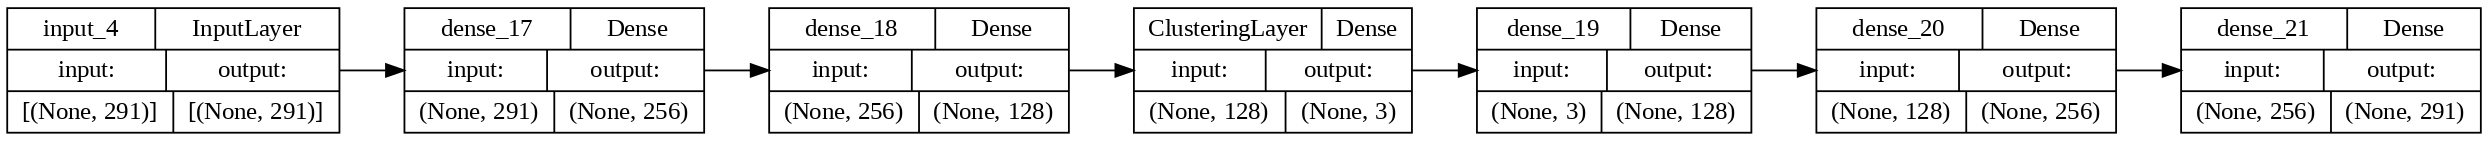

In [ ]:
# This is the size of our input data
full_dim = two_sample_fitted.shape.as_list()[1]

# these are the downsampling/upsampling dimensions
encoding_dim1 = 256
encoding_dim2 = 128
encoding_dim3 = 3 # we will use these 3 dimensions for clustering

# This is our encoder input
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoded_layer3 = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)


# the reconstruction of the input
decoded_layer3 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer3)
decoded_layer2 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer3)
decoded_layer1 = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer2)

# This model maps an input to its autoencoder reconstruction
autoencoder_model = keras.Model(encoder_input_data, outputs=decoded_layer1, name="Encoder")

# compile the model
autoencoder_model.compile(optimizer="adam", loss=tf.keras.losses.mean_squared_error)
tf.keras.utils.plot_model(model=autoencoder_model, rankdir="LR", dpi=130, show_shapes=True)

In [ ]:
# process the inputs
p_items = preprocessing_layer(data_features_dict)

# split into training and testing sets (80/20 split)
train_data, test_data, train_labels, test_labels = train_test_split(p_items.numpy(), revenue, train_size=0.8, random_state=42)

# fit the model using the training data
fitting = autoencoder_model.fit(train_data, train_data, epochs=500, batch_size=256, shuffle=True, validation_split = 0.9)


Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.9116 - val_loss: 1.1385
Epoch 2/500
1/1 [==============================] - 0s 39ms/step - loss: 0.9048 - val_loss: 1.1350
Epoch 3/500
1/1 [==============================] - 0s 46ms/step - loss: 0.8922 - val_loss: 1.1296
Epoch 4/500
1/1 [==============================] - 0s 50ms/step - loss: 0.8729 - val_loss: 1.1220
Epoch 5/500
1/1 [==============================] - 0s 42ms/step - loss: 0.8462 - val_loss: 1.1119
Epoch 6/500
1/1 [==============================] - 0s 39ms/step - loss: 0.8116 - val_loss: 1.0988
Epoch 7/500
1/1 [==============================] - 0s 38ms/step - loss: 0.7684 - val_loss: 1.0827
Epoch 8/500
1/1 [==============================] - 0s 41ms/step - loss: 0.7180 - val_loss: 1.0637
Epoch 9/500
1/1 [==============================] - 0s 44ms/step - loss: 0.6625 - val_loss: 1.0426
Epoch 10/500
1/1 [==============================] - 0s 40ms/step - loss: 0.6060 - val_loss: 1.0204
Epoch 11/500
1/1 [===

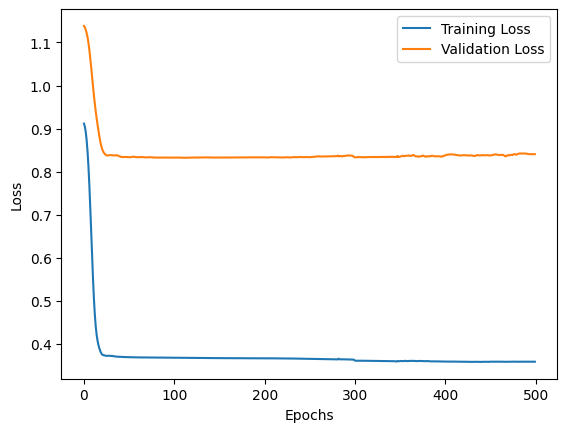

In [ ]:
import matplotlib.pyplot as plt

# Train the autoencoder and store the training history
history = fitting

# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the training loss and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

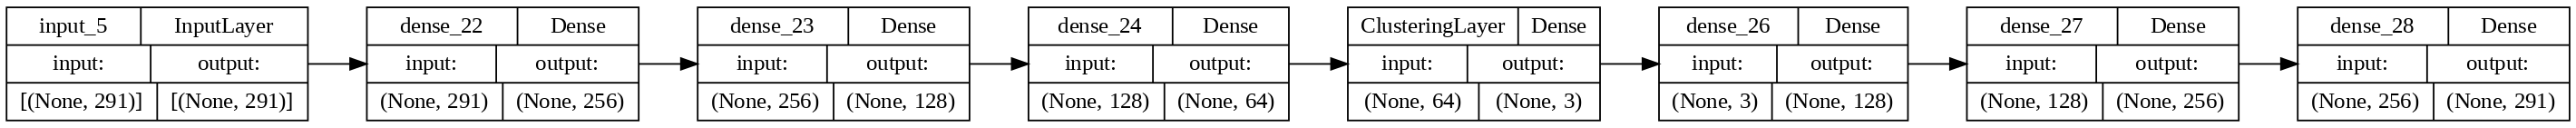

In [ ]:
# This is the size of our input data
full_dim = two_sample_fitted.shape.as_list()[1]

# these are the downsampling/upsampling dimensions
encoding_dim1 = 256
encoding_dim2 = 128
encoding_dim3 = 64
encoding_dim4 = 3

# This is our encoder input
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
encoded_layer3 = keras.layers.Dense(encoding_dim3, activation='relu')(encoded_layer2)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoded_layer4 = keras.layers.Dense(encoding_dim4, activation='relu', name="ClusteringLayer")(encoded_layer3)


# the reconstruction of the input
decoded_layer4 = keras.layers.Dense(encoding_dim3, activation='relu')(encoded_layer4)
decoded_layer3 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer4)
decoded_layer2 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer3)
decoded_layer1 = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer2)

# This model maps an input to its autoencoder reconstruction
autoencoder_model = keras.Model(encoder_input_data, outputs=decoded_layer1, name="Encoder")

# compile the model
autoencoder_model.compile(optimizer="adam", loss=tf.keras.losses.mean_squared_error)
tf.keras.utils.plot_model(model=autoencoder_model, rankdir="LR", dpi=130, show_shapes=True)

In [ ]:
# process the inputs
p_items = preprocessing_layer(data_features_dict)

# split into training and testing sets (80/20 split)
train_data, test_data, train_labels, test_labels = train_test_split(p_items.numpy(), revenue, train_size=0.8, random_state=44)

# fit the model using the training data
fitting2 = autoencoder_model.fit(train_data, train_data, epochs=500, batch_size=256, shuffle=True, validation_split=0.9)


Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.9048 - val_loss: 1.0561
Epoch 2/500
1/1 [==============================] - 0s 48ms/step - loss: 0.9033 - val_loss: 1.0557
Epoch 3/500
1/1 [==============================] - 0s 42ms/step - loss: 0.8982 - val_loss: 1.0551
Epoch 4/500
1/1 [==============================] - 0s 40ms/step - loss: 0.8890 - val_loss: 1.0540
Epoch 5/500
1/1 [==============================] - 0s 41ms/step - loss: 0.8749 - val_loss: 1.0525
Epoch 6/500
1/1 [==============================] - 0s 45ms/step - loss: 0.8556 - val_loss: 1.0502
Epoch 7/500
1/1 [==============================] - 0s 37ms/step - loss: 0.8310 - val_loss: 1.0471
Epoch 8/500
1/1 [==============================] - 0s 38ms/step - loss: 0.8013 - val_loss: 1.0430
Epoch 9/500
1/1 [==============================] - 0s 40ms/step - loss: 0.7681 - val_loss: 1.0378
Epoch 10/500
1/1 [==============================] - 0s 42ms/step - loss: 0.7339 - val_loss: 1.0319
Epoch 11/500
1/1 [===

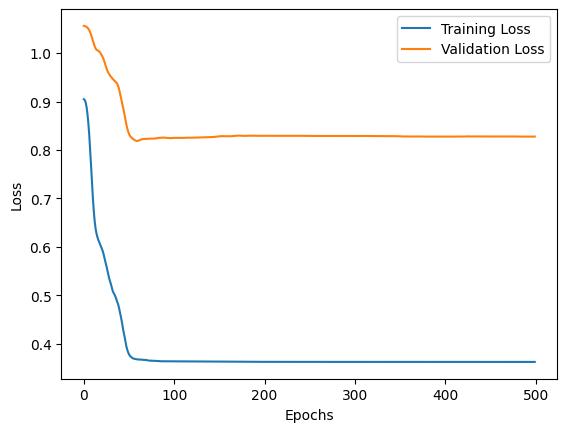

In [ ]:
# Train the autoencoder and store the training history
history2 = fitting2

# Access the training history
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

# Plotting the training loss and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Train the autoencoder
autoencoder_model.fit(train_data, train_data, epochs=150, batch_size=32, validation_data=(test_data,test_data))

# Test the autoencoder by encoding and decoding the test set
encoded_data = encoder_model.predict(test_data)
decoded_data = autoencoder_model.predict(test_data)
